In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from google.colab import drive
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import os
import pickle

Import data.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Virtual Experience/'

df_client = pd.read_csv(path + 'client_data.csv')
df_price = pd.read_csv(path + 'price_data.csv')

Function to convert column to datetime type.

In [4]:
def convert_to_date(column: pd.Series = None):
    column = pd.to_datetime(column, format='%Y-%m-%d')
#     print(column.dtypes)
    return column

## Client data

In [5]:
df_client.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  date_activ    date_end  \
0         0         54946                0  2013-06-15  2016-06-15   
1      4660             0                0  2009-08-21  2016-08-30   
2       544             0                0  2010-04-16  2016-04-16   
3      1584             0                0  2010-03-30  2016-03-30   
4      4425             0              526  2010-01-13  2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  has_gas  imp_cons  \
0      2015-11-01   2015-06-23               0.00  ...        t      0.00   
1      2009-08-21   2015-08-31             189.95  ...        f      0.00   
2      2010-04-16   2015-04-17              47.96  ...        f      0.00   
3      2010-03-30   2015-03-31             240.04  ...        f      0.00   
4      2010-01-13   2015-03-09             445.75  ...        f     52.32   

   margin_gross_pow_ele  margin_net_pow_ele  nb_prod_act  net_margin  \
0                 25.44               25.44            2      678.99   
1                 16.38               16.38            1       18.89   
2                 28.60               28.60            1        6.60   
3                 30.22               30.22            1       25.46   
4                 44.91               44.91            1       47.98   

  num_years_antig                         origin_up  pow_max  churn  
0               3  lxidpiddsbxsbosboudacockeimpuepw   43.648      1  
1               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.800      0  
2               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.856      0  
3               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   13.200      0  
4               6  kamkkxfxxuwbdslkwifmmcsiusiuosws   19.800      0  

[5 rows x 26 columns]

In [6]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

Change the column names so that they will be clearer.

In [7]:
rename_columns = {'cons_12m': 'electricity_consumption_past_12_months',
                  'cons_gas_12m': 'gas_consumption_past_12_months',
                  'cons_last_month': 'electricity_consumption_last_month',
                  'date_activ': 'activation_date',
                  'date_end': 'end_date',
                  'date_modif_prod': 'product_modification_last_date',
                  'date_renewal': 'renewal_date',
                  'forecast_cons_12m': 'electricity_consumption_next_12_months_forecast',
                  'forecast_cons_year': 'electricity_consumption_next_year_forecast',
                  'forecast_meter_rent_12m': 'meter_rent_next_12_months_forecast',
                  'forecast_price_pow_off_peak': 'off_peak_power_price_forecast',
                  'forecast_price_energy_off_peak': 'off_peak_energy_price_forecast',
                  'forecast_price_pow_peak': 'peak_energy_price_forecast',
                  'imp_cons': 'paid_consumption',
                  'margin_gross_pow_ele': 'power_subscription_gross_margin',
                  'margin_net_pow_ele': 'power_subscription_net_margin',
                  'nb_prod_act': 'active_product_number',
                  'num_years_antig': 'client_antiquity_in_years',
                  'origin_up': 'origin_campaign',
                  'pow_max': 'subscribed_power'
                 }

In [8]:
df_client = df_client.rename(columns=rename_columns)
# df_client.info()

In [9]:
date_columns = ['activation_date', 'end_date', 'product_modification_last_date', 'renewal_date']

for column_name in date_columns:
    df_client[column_name] = convert_to_date(df_client[column_name])

In [10]:
df_client['churn'] = df_client['churn'].astype('str')

In [11]:
numerical_columns = list(df_client.select_dtypes('number').columns)
numerical_columns.append('churn')
# numerical_columns

Visualize the numerical columns in pairplot. Commenting this code because it takes a long time to run. We load the image from previous run instead.

In [12]:
# sns.set(rc={'figure.figsize':(70, 70), 'axes.labelsize':7})
# sns.pairplot(df_client[numerical_columns], hue='churn', plot_kws={'s':3})

Instead running the above code again, we just show the image produced from previous run. It's the same.

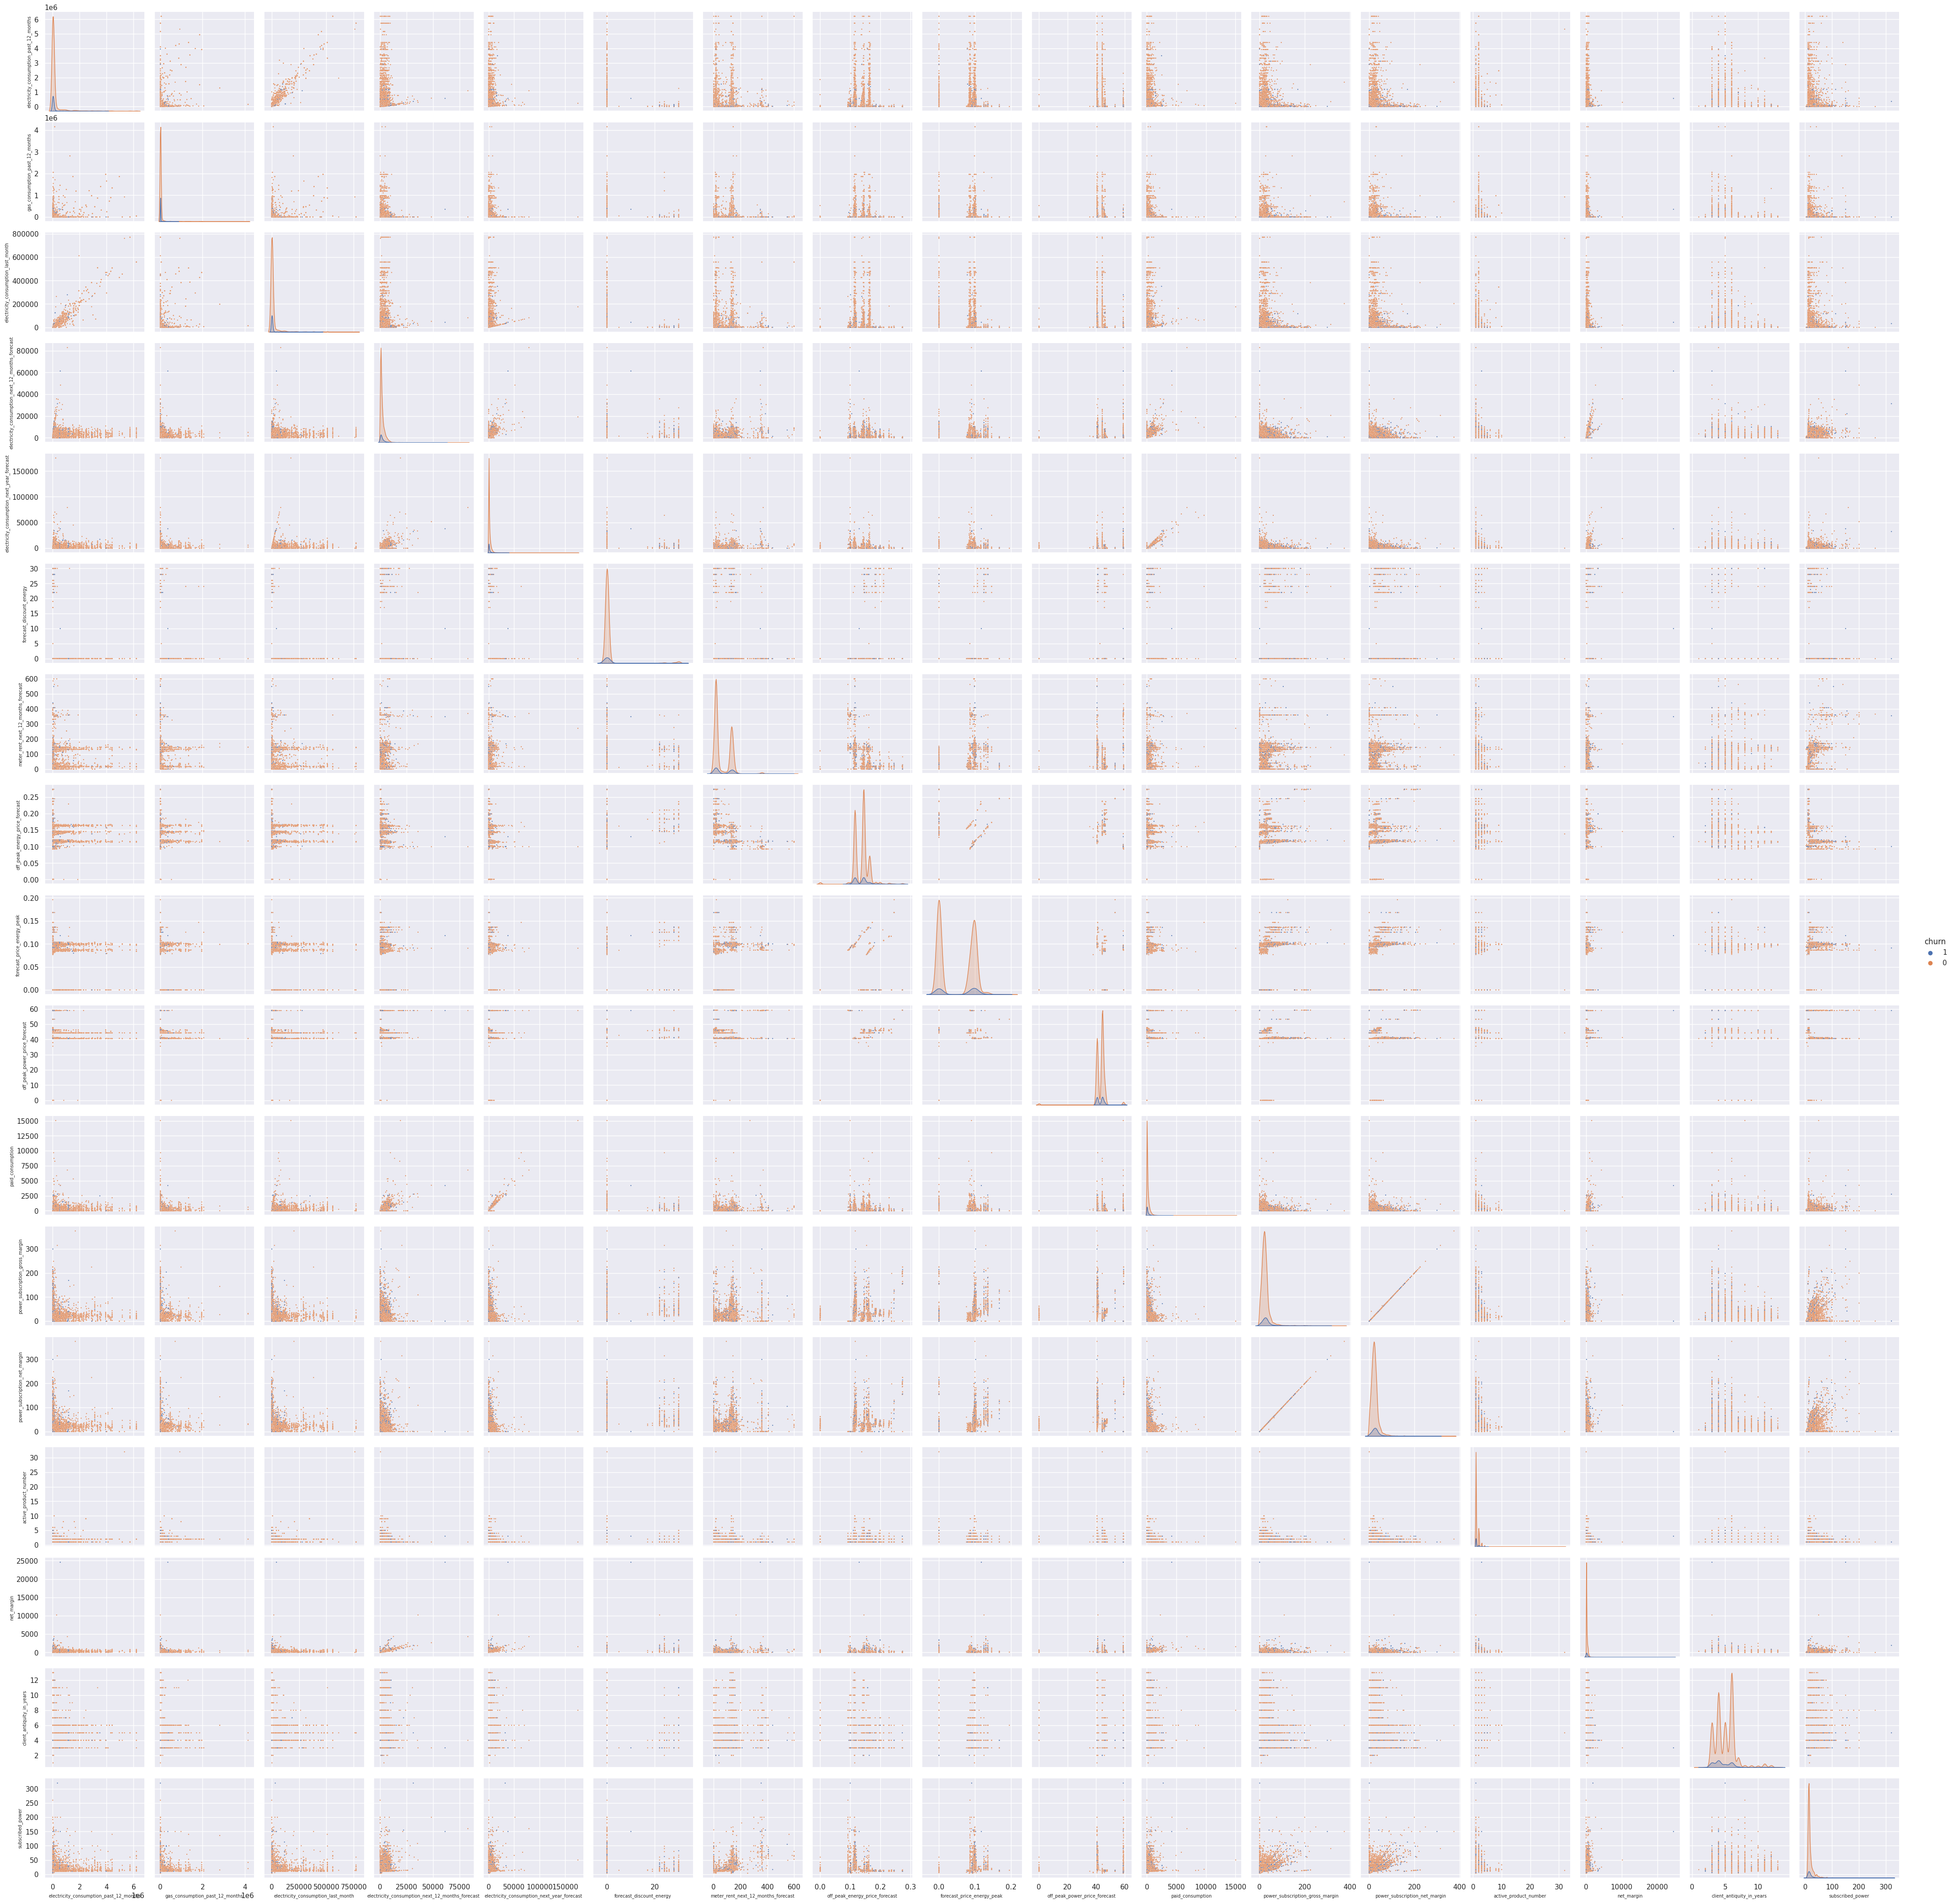

In [13]:
Image(path + 'bcg_pairplot.png')

Visualize the categorical columns.

In [14]:
categorical_columns = list(df_client.select_dtypes('object').columns)
categorical_columns

['id', 'channel_sales', 'has_gas', 'origin_campaign', 'churn']

In [15]:
# idx = 0
# fig, axes = plt.subplots(3, 2, figsize=(10, 10))
# axes[-1, -1].axis('off')
# for i in list(range(3)):
#   for j in list(range(2)):
#     if idx < 5:
#       ax = sns.countplot(ax=axes[i, j], data=df_client, x=categorical_columns[idx], lw=0, hue='churn', order=df_client[categorical_columns[idx]].value_counts().index)
#       ax.set(xticklabels=[])
#       idx +=1

I'm also loading the bar plot for categorical columns from the previous run because the above code also run slowly.

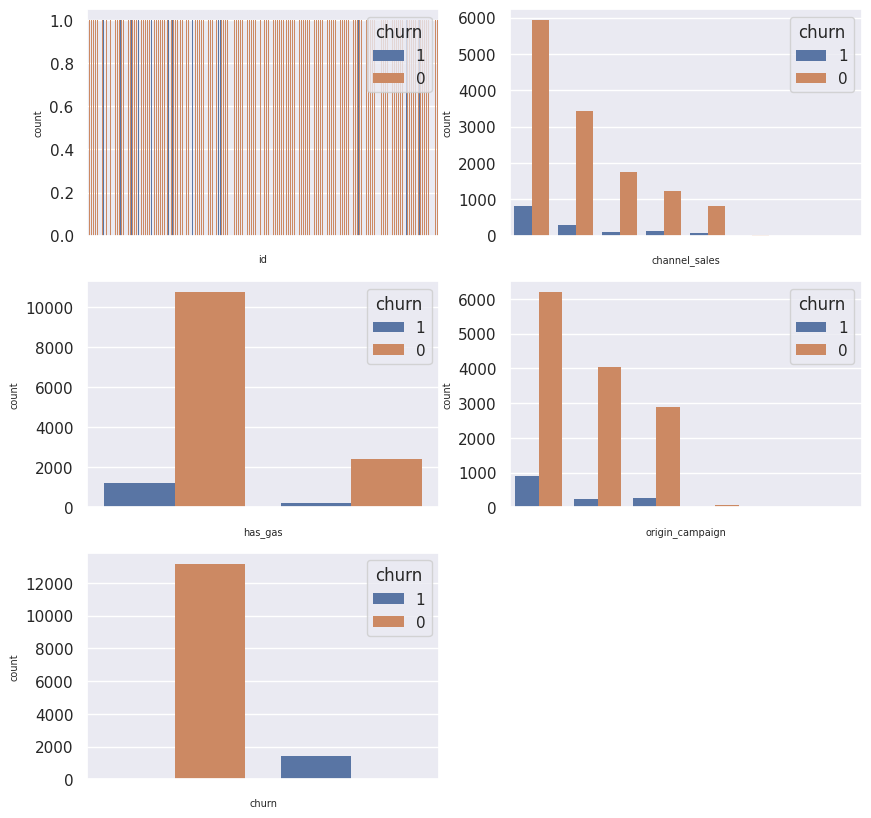

In [16]:
Image(path + 'bcg_barplot.png')

## Price data

In [17]:
df_price.head()

id  price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745  2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745  2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745  2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745  2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745  2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [18]:
df_price['price_date'] = convert_to_date(df_price['price_date'])
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB


Unique values in price date column.

In [19]:
len(df_price['price_date'].unique())

12

Unique values in id column.

In [20]:
len(df_price['id'].unique())

16096

In [21]:
df_price.head()

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745 2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745 2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745 2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745 2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

Aggregating the price data by mean, median, max, min, and standard deviation values.

In [22]:
df_price_mean = df_price.groupby(['id']).mean().reset_index().add_suffix('_mean')
df_price_mean = df_price_mean.rename(columns={'id_mean':'id'})
df_price_mean.head()

<ipython-input-22-be0d8e4ffa83>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_price_mean = df_price.groupby(['id']).mean().reset_index().add_suffix('_mean')


id  price_off_peak_var_mean  \
0  0002203ffbb812588b632b9e628cc38d                 0.124338   
1  0004351ebdd665e6ee664792efc4fd13                 0.146426   
2  0010bcc39e42b3c2131ed2ce55246e3c                 0.181558   
3  0010ee3855fdea87602a5b7aba8e42de                 0.118757   
4  00114d74e963e47177db89bc70108537                 0.147926   

   price_peak_var_mean  price_mid_peak_var_mean  price_off_peak_fix_mean  \
0             0.103794                 0.073160                40.701732   
1             0.000000                 0.000000                44.385450   
2             0.000000                 0.000000                45.319710   
3             0.098292                 0.069032                40.647427   
4             0.000000                 0.000000                44.266930   

   price_peak_fix_mean  price_mid_peak_fix_mean  
0            24.421038                16.280694  
1             0.000000                 0.000000  
2             0.000000                 0.000000  
3            24.388455                16.258971  
4             0.000000                 0.000000

In [23]:
df_price_std = df_price.groupby(['id']).std().reset_index().add_suffix('_std')
df_price_std = df_price_std.rename(columns={'id_std':'id'})
df_price_std.head()

<ipython-input-23-6db20bedae2c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_price_std = df_price.groupby(['id']).std().reset_index().add_suffix('_std')


id  price_off_peak_var_std  \
0  0002203ffbb812588b632b9e628cc38d                0.003976   
1  0004351ebdd665e6ee664792efc4fd13                0.002197   
2  0010bcc39e42b3c2131ed2ce55246e3c                0.026008   
3  0010ee3855fdea87602a5b7aba8e42de                0.005049   
4  00114d74e963e47177db89bc70108537                0.002202   

   price_peak_var_std  price_mid_peak_var_std  price_off_peak_fix_std  \
0            0.001989                0.001368            6.341481e-02   
1            0.000000                0.000000            8.753223e-02   
2            0.000000                0.000000            7.723930e-01   
3            0.002580                0.000403            8.507958e-02   
4            0.000000                0.000000            5.908392e-07   

   price_peak_fix_std  price_mid_peak_fix_std  
0            0.038049                0.025366  
1            0.000000                0.000000  
2            0.000000                0.000000  
3            0.051048                0.034032  
4            0.000000                0.000000

In [24]:
df_price_min = df_price.groupby(['id']).min().reset_index().add_suffix('_min')
df_price_min = df_price_min.rename(columns={'id_min':'id'})
df_price_min.head()

id price_date_min  price_off_peak_var_min  \
0  0002203ffbb812588b632b9e628cc38d     2015-01-01                0.119906   
1  0004351ebdd665e6ee664792efc4fd13     2015-01-01                0.143943   
2  0010bcc39e42b3c2131ed2ce55246e3c     2015-01-01                0.150837   
3  0010ee3855fdea87602a5b7aba8e42de     2015-01-01                0.113068   
4  00114d74e963e47177db89bc70108537     2015-01-01                0.145440   

   price_peak_var_min  price_mid_peak_var_min  price_off_peak_fix_min  \
0            0.101673                0.070232               40.565969   
1            0.000000                0.000000               44.266931   
2            0.000000                0.000000               44.444710   
3            0.095385                0.068646               40.565969   
4            0.000000                0.000000               44.266930   

   price_peak_fix_min  price_mid_peak_fix_min  
0           24.339581               16.226389  
1            0.000000                0.000000  
2            0.000000                0.000000  
3           24.339578               16.226383  
4            0.000000                0.000000

In [25]:
df_price_max = df_price.groupby(['id']).max().reset_index().add_suffix('_max')
df_price_max = df_price_max.rename(columns={'id_max':'id'})
df_price_max.head()

id price_date_max  price_off_peak_var_max  \
0  0002203ffbb812588b632b9e628cc38d     2015-12-01                0.128067   
1  0004351ebdd665e6ee664792efc4fd13     2015-12-01                0.148405   
2  0010bcc39e42b3c2131ed2ce55246e3c     2015-12-01                0.205742   
3  0010ee3855fdea87602a5b7aba8e42de     2015-12-01                0.123086   
4  00114d74e963e47177db89bc70108537     2015-12-01                0.149902   

   price_peak_var_max  price_mid_peak_var_max  price_off_peak_fix_max  \
0            0.105842                0.073773               40.728885   
1            0.000000                0.000000               44.444710   
2            0.000000                0.000000               45.944710   
3            0.100505                0.069463               40.728885   
4            0.000000                0.000000               44.266931   

   price_peak_fix_max  price_mid_peak_fix_max  
0            24.43733               16.291555  
1             0.00000                0.000000  
2             0.00000                0.000000  
3            24.43733               16.291555  
4             0.00000                0.000000

In [26]:
df_price_median = df_price.groupby(['id']).median().reset_index().add_suffix('_median')
df_price_median = df_price_median.rename(columns={'id_median':'id'})
df_price_median.head()

<ipython-input-26-ddf72d919f96>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_price_median = df_price.groupby(['id']).median().reset_index().add_suffix('_median')


id  price_off_peak_var_median  \
0  0002203ffbb812588b632b9e628cc38d                   0.126098   
1  0004351ebdd665e6ee664792efc4fd13                   0.148047   
2  0010bcc39e42b3c2131ed2ce55246e3c                   0.201280   
3  0010ee3855fdea87602a5b7aba8e42de                   0.122157   
4  00114d74e963e47177db89bc70108537                   0.149434   

   price_peak_var_median  price_mid_peak_var_median  \
0               0.103975                   0.073719   
1               0.000000                   0.000000   
2               0.000000                   0.000000   
3               0.100029                   0.069027   
4               0.000000                   0.000000   

   price_off_peak_fix_median  price_peak_fix_median  price_mid_peak_fix_median  
0                  40.728885              24.437330                  16.291555  
1                  44.444710               0.000000                   0.000000  
2                  45.944710               0.000000                   0.000000  
3                  40.647429              24.388455                  16.258972  
4                  44.266930               0.000000                   0.000000

In [27]:
# del df_price_agg
df_price_agg = pd.merge(df_price_mean, df_price_median, on='id')
df_price_agg = pd.merge(df_price_agg, df_price_max, on='id')
df_price_agg = pd.merge(df_price_agg, df_price_min, on='id')
df_price_agg = pd.merge(df_price_agg, df_price_std, on='id')
df_price_agg = df_price_agg.drop(columns=['price_date_min', 'price_date_max'])
df_price_agg = pd.merge(df_price_agg, df_client[['id', 'churn']], on='id')
df_price_agg.head()

id  price_off_peak_var_mean  \
0  0002203ffbb812588b632b9e628cc38d                 0.124338   
1  0004351ebdd665e6ee664792efc4fd13                 0.146426   
2  0010bcc39e42b3c2131ed2ce55246e3c                 0.181558   
3  00114d74e963e47177db89bc70108537                 0.147926   
4  0013f326a839a2f6ad87a1859952d227                 0.126076   

   price_peak_var_mean  price_mid_peak_var_mean  price_off_peak_fix_mean  \
0             0.103794                 0.073160                40.701732   
1             0.000000                 0.000000                44.385450   
2             0.000000                 0.000000                45.319710   
3             0.000000                 0.000000                44.266930   
4             0.105542                 0.074921                40.728885   

   price_peak_fix_mean  price_mid_peak_fix_mean  price_off_peak_var_median  \
0            24.421038                16.280694                   0.126098   
1             0.000000                 0.000000                   0.148047   
2             0.000000                 0.000000                   0.201280   
3             0.000000                 0.000000                   0.149434   
4            24.437330                16.291555                   0.127818   

   price_peak_var_median  price_mid_peak_var_median  ...  \
0               0.103975                   0.073719  ...   
1               0.000000                   0.000000  ...   
2               0.000000                   0.000000  ...   
3               0.000000                   0.000000  ...   
4               0.105764                   0.075460  ...   

   price_off_peak_fix_min  price_peak_fix_min  price_mid_peak_fix_min  \
0               40.565969           24.339581               16.226389   
1               44.266931            0.000000                0.000000   
2               44.444710            0.000000                0.000000   
3               44.266930            0.000000                0.000000   
4               40.728885           24.437330               16.291555   

   price_off_peak_var_std  price_peak_var_std  price_mid_peak_var_std  \
0                0.003976            0.001989                0.001368   
1                0.002197            0.000000                0.000000   
2                0.026008            0.000000                0.000000   
3                0.002202            0.000000                0.000000   
4                0.003975            0.001990                0.001323   

   price_off_peak_fix_std  price_peak_fix_std  price_mid_peak_fix_std  churn  
0            6.341481e-02            0.038049                0.025366      0  
1            8.753223e-02            0.000000                0.000000      0  
2            7.723930e-01            0.000000                0.000000      0  
3            5.908392e-07            0.000000                0.000000      0  
4            0.000000e+00            0.000000                0.000000      0  

[5 rows x 32 columns]

In [28]:
# df_price_agg.info()

<ipython-input-29-7182f90649cd>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_price_agg.corr(), annot=True)


<Axes: >

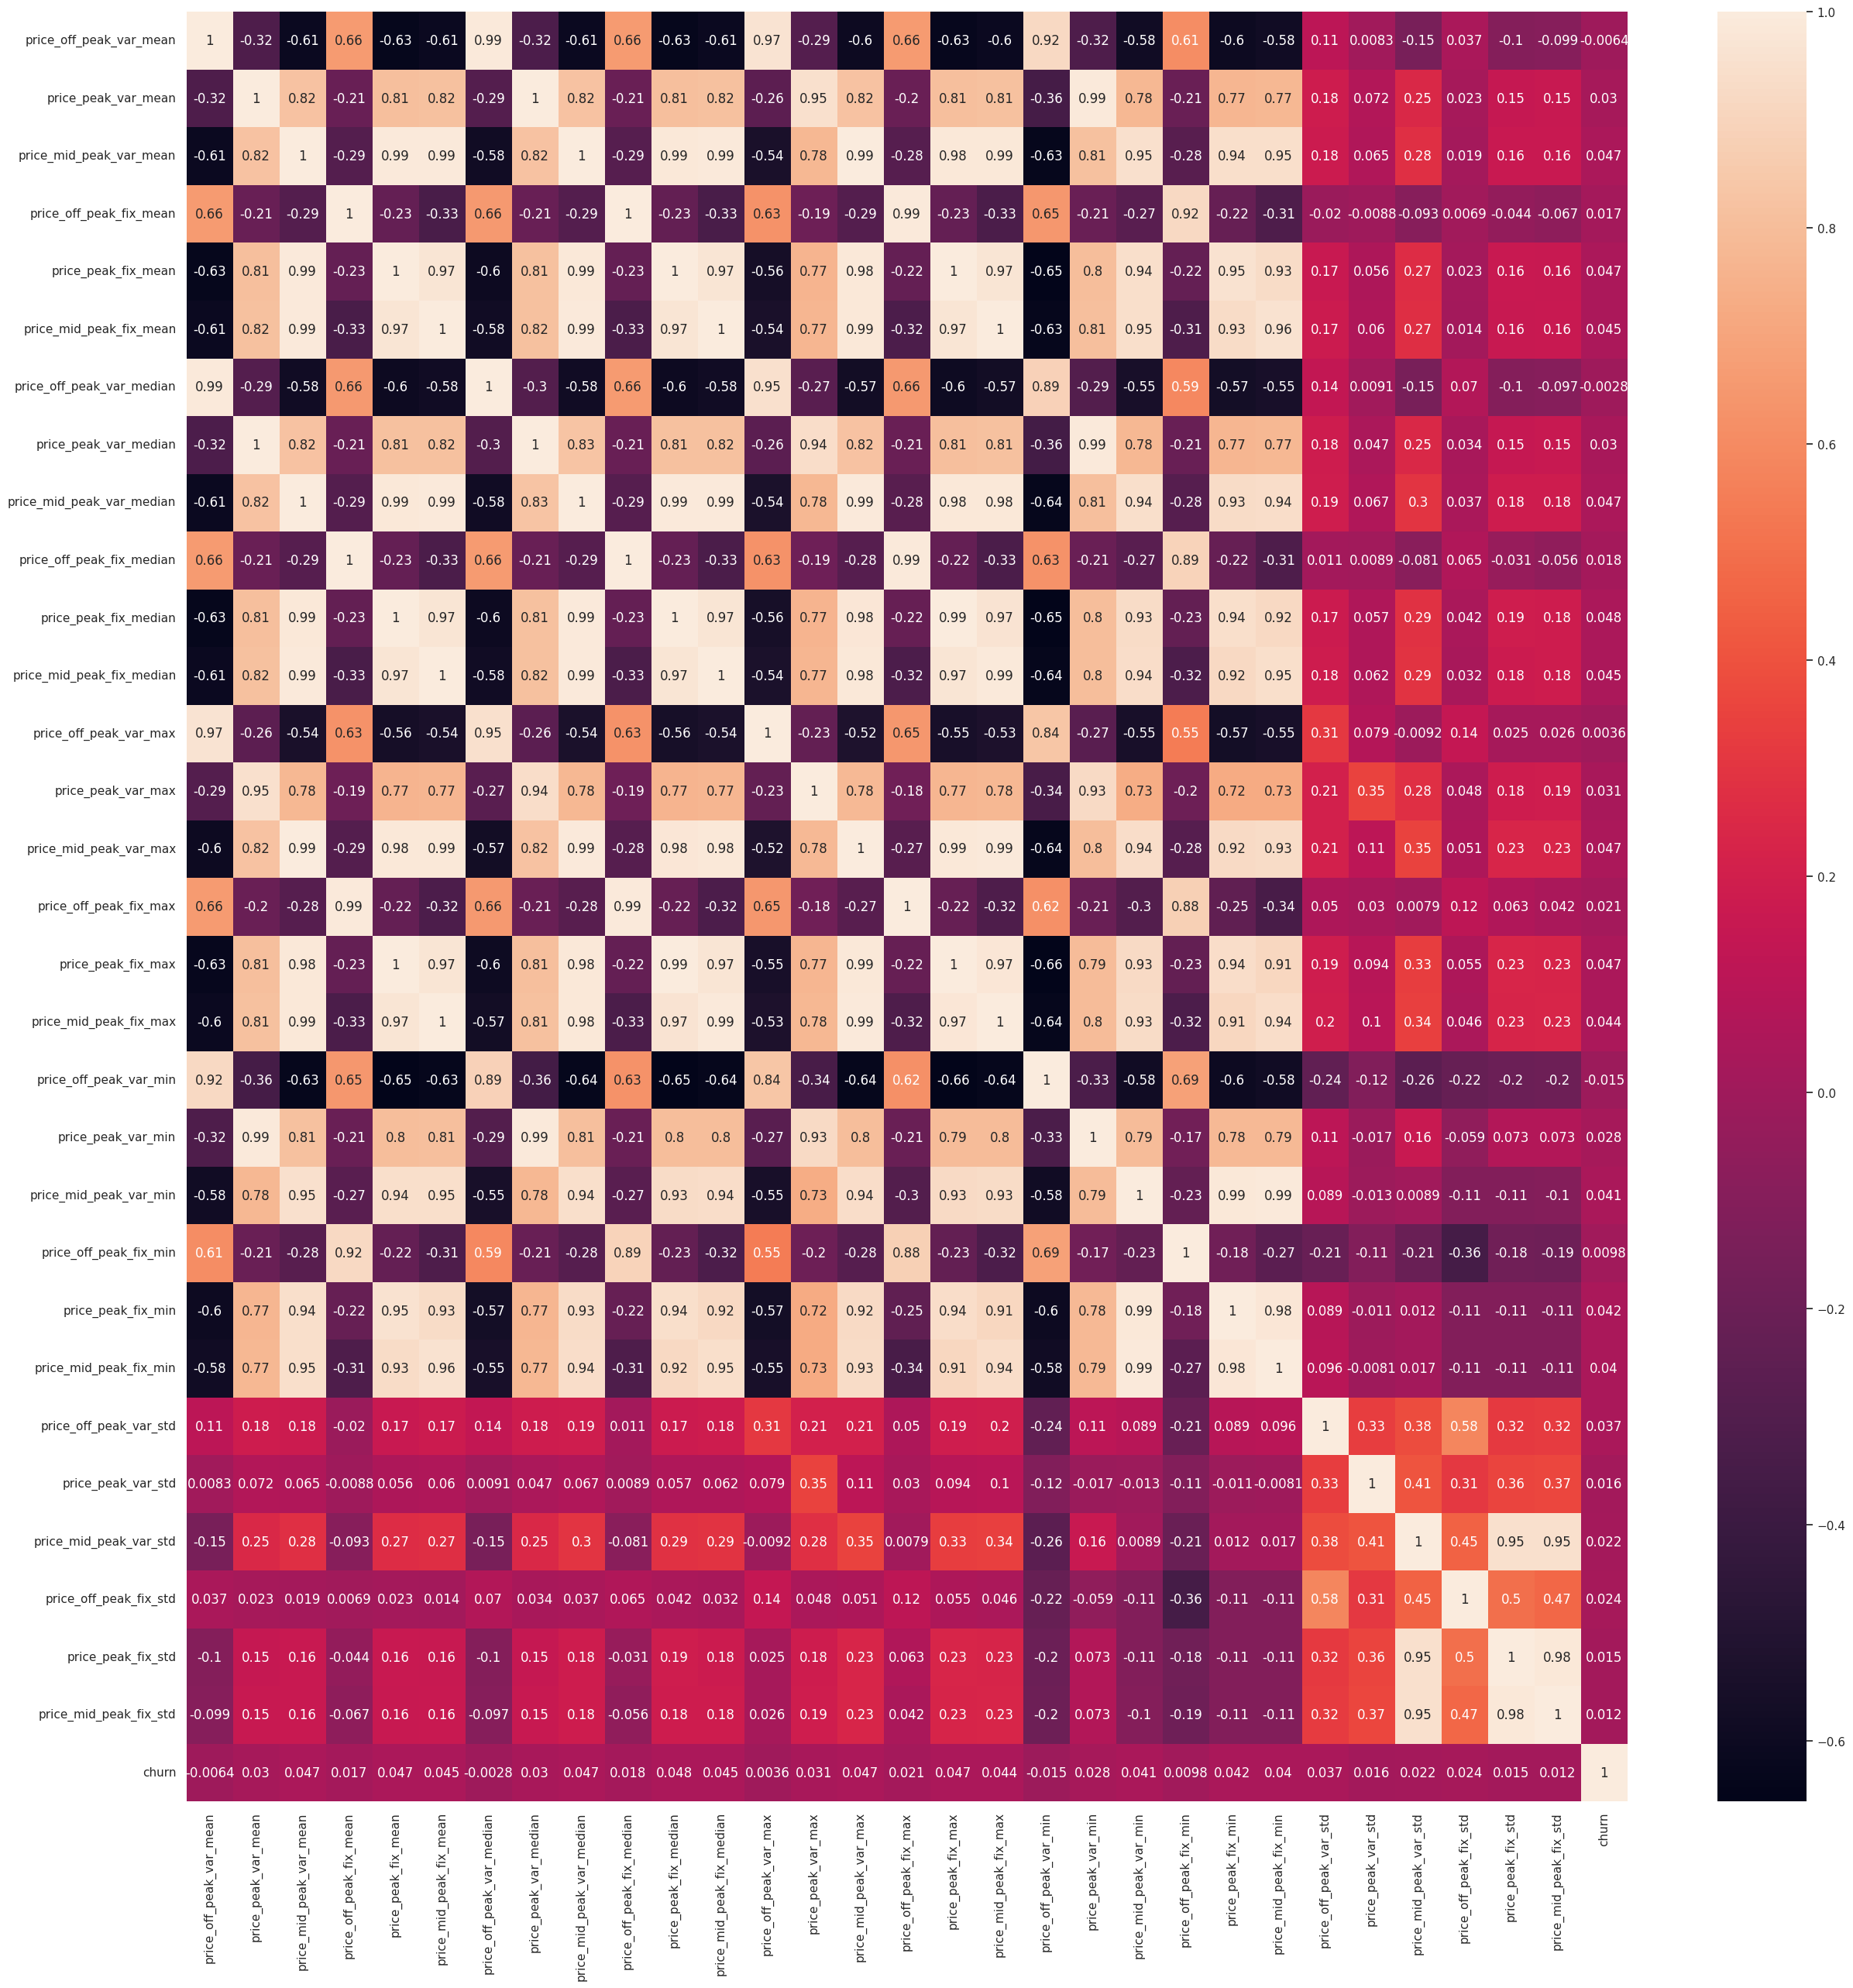

In [29]:
sns.set(rc={'figure.figsize':(30, 30)})
df_price_agg['churn'] = df_price_agg['churn'].astype(int)
sns.heatmap(df_price_agg.corr(), annot=True)

Pivot the price data columns. So we make a column for every month for every price category.

In [30]:
column_list = list(df_price.columns)
column_list.remove('id')
column_list.remove('price_date')
column_list

['price_off_peak_var',
 'price_peak_var',
 'price_mid_peak_var',
 'price_off_peak_fix',
 'price_peak_fix',
 'price_mid_peak_fix']

In [31]:
df_price1 = df_price.copy()
df_price1['price_date'] = df_price1['price_date'].astype(str)

df_price2 = pd.DataFrame({'id': df_price_agg['id']})

for column in column_list:

  df_price3 = df_price1.pivot(index = ['id'], columns = 'price_date', values=[column]).reset_index()
  df_price3.columns = df_price3.columns.map('_'.join)
  df_price3 = df_price3.rename(columns={'id_':'id'})
  df_price3 = df_price3.fillna(0)
  df_price2 = pd.merge(df_price2, df_price3, on='id')

In [32]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   id                                               14606 non-null  object        
 1   channel_sales                                    14606 non-null  object        
 2   electricity_consumption_past_12_months           14606 non-null  int64         
 3   gas_consumption_past_12_months                   14606 non-null  int64         
 4   electricity_consumption_last_month               14606 non-null  int64         
 5   activation_date                                  14606 non-null  datetime64[ns]
 6   end_date                                         14606 non-null  datetime64[ns]
 7   product_modification_last_date                   14606 non-null  datetime64[ns]
 8   renewal_date                        

Extract the number of months from start date, last renewal, last product modification to end date (if churn) or reference date (if not churn).

In [33]:
def months_to_reference(column):
  time_delta = reference_date - df_client[column]
  months = (time_delta/np.timedelta64(1, 'M')).astype(int)
  return months

def months_to_end(column):
  time_delta = df_client['end_date'] - df_client[column]
  months = (time_delta/np.timedelta64(1, 'M')).astype(int)
  return months

reference_date = datetime(2016, 1, 28)
condition_list = [df_client['churn'] == '1', df_client['churn'] == '0']
choice_list_activation = [months_to_end('activation_date'), months_to_reference('activation_date')]
choice_list_renewal = [months_to_end('renewal_date'), months_to_reference('renewal_date')]
choice_list_modification = [months_to_end('product_modification_last_date'), months_to_reference('product_modification_last_date')]
df_client['months_active'] = np.select(condition_list, choice_list_activation)
df_client['months_last_renewal'] = np.select(condition_list, choice_list_renewal)
df_client['months_last_modification'] = np.select(condition_list, choice_list_modification)

# df_client.head()

In [34]:
df_client = df_client.drop(columns=['activation_date', 'end_date', 'renewal_date', 'product_modification_last_date'])
# df_client.info()

In [35]:
df_client['channel_sales'].unique()

array(['foosdfpfkusacimwkcsosbicdxkicaua', 'MISSING',
       'lmkebamcaaclubfxadlmueccxoimlema',
       'usilxuppasemubllopkaafesmlibmsdf',
       'ewpakwlliwisiwduibdlfmalxowmwpci',
       'epumfxlbckeskwekxbiuasklxalciiuu',
       'sddiedcslfslkckwlfkdpoeeailfpeds',
       'fixdbufsefwooaasfcxdxadsiekoceaa'], dtype=object)

Check the channel sales column.

<Axes: xlabel='count', ylabel='channel_sales'>

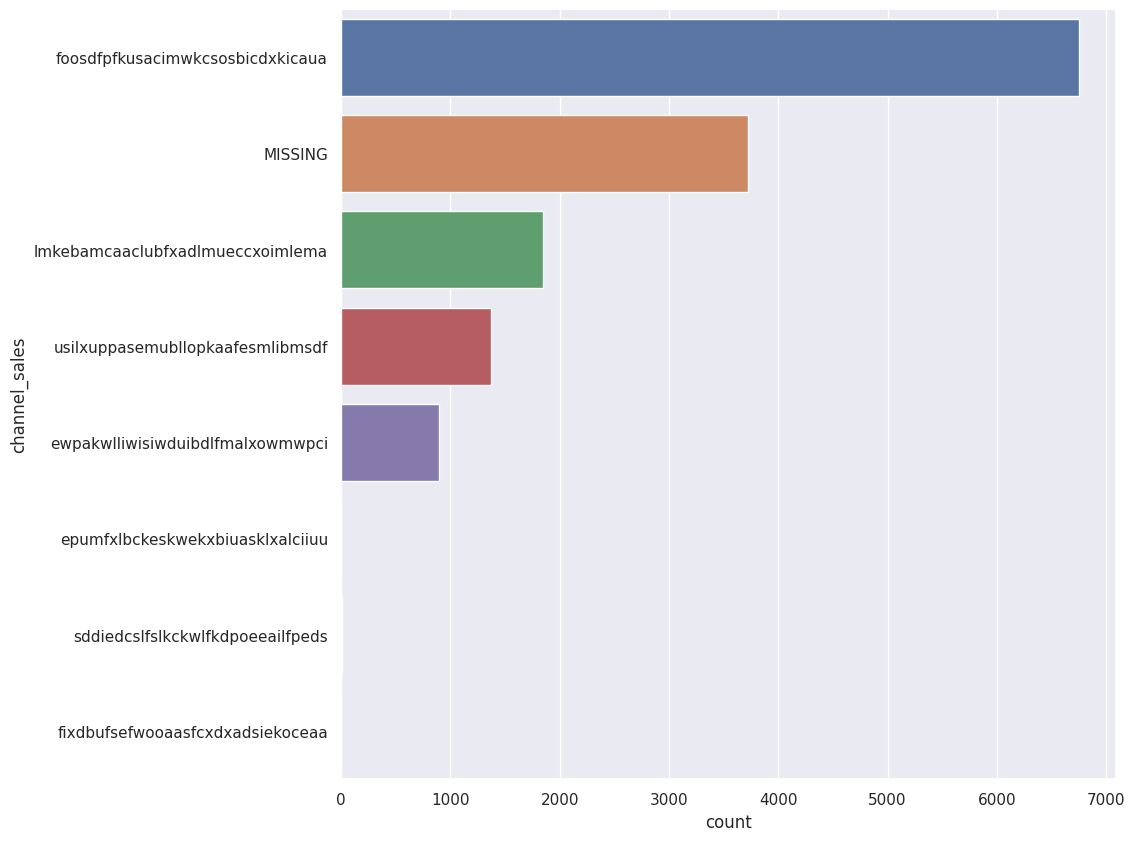

In [36]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.countplot(data=df_client, y='channel_sales')

In [37]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 25 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               14606 non-null  object 
 1   channel_sales                                    14606 non-null  object 
 2   electricity_consumption_past_12_months           14606 non-null  int64  
 3   gas_consumption_past_12_months                   14606 non-null  int64  
 4   electricity_consumption_last_month               14606 non-null  int64  
 5   electricity_consumption_next_12_months_forecast  14606 non-null  float64
 6   electricity_consumption_next_year_forecast       14606 non-null  int64  
 7   forecast_discount_energy                         14606 non-null  float64
 8   meter_rent_next_12_months_forecast               14606 non-null  float64
 9   off_peak_energy_price_foreca

Check origin campaign column.

<Axes: xlabel='count', ylabel='origin_campaign'>

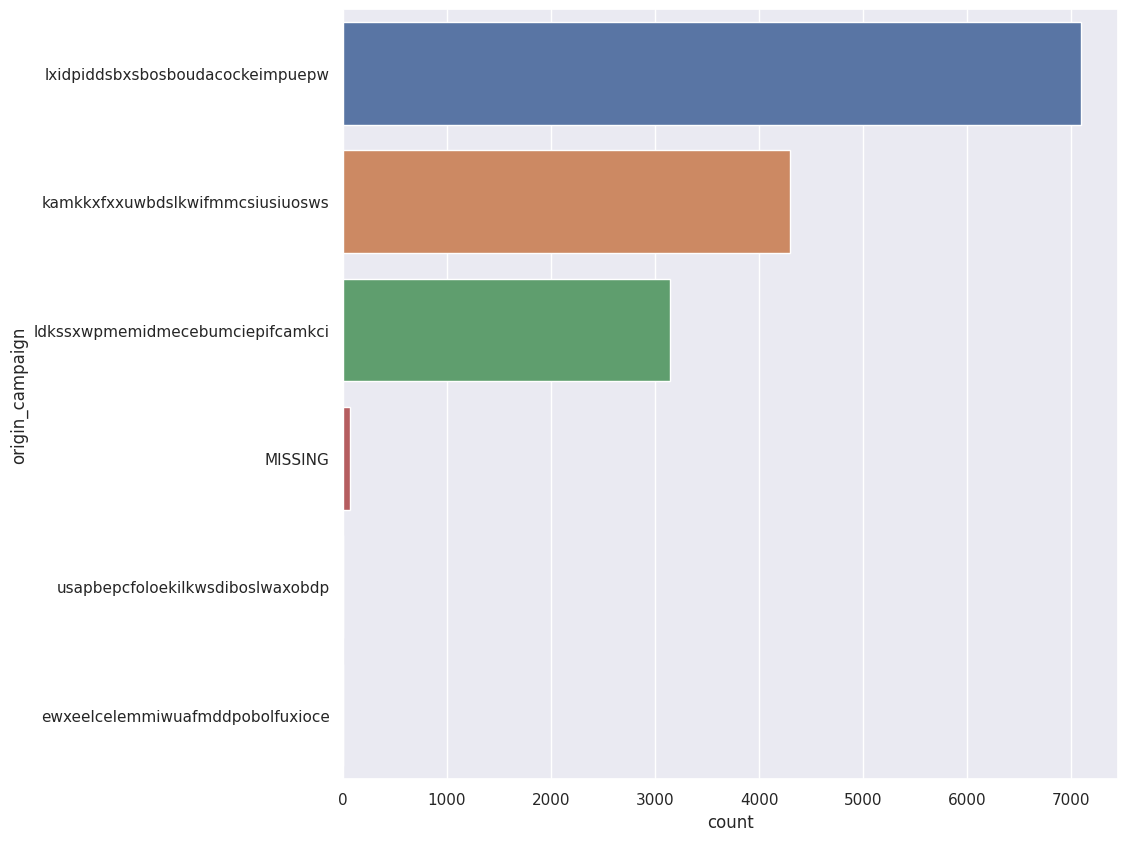

In [38]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.countplot(data=df_client, y='origin_campaign')

So the has gas, origin campaign, and sales channel columns can be safely made dummy variables.

In [39]:
df_client['has_gas'] = pd.get_dummies(df_client['has_gas'], drop_first=True)
# df_client.head()

In [40]:
dummies = pd.get_dummies(df_client[['channel_sales', 'origin_campaign']], prefix=['sales_channel', 'origin_campaign'])
dummies

sales_channel_MISSING  sales_channel_epumfxlbckeskwekxbiuasklxalciiuu  \
0                          0                                               0   
1                          1                                               0   
2                          0                                               0   
3                          0                                               0   
4                          1                                               0   
...                      ...                                             ...   
14601                      0                                               0   
14602                      0                                               0   
14603                      0                                               0   
14604                      0                                               0   
14605                      1                                               0   

       sales_channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   
...                                               ...   
14601                                               0   
14602                                               0   
14603                                               0   
14604                                               0   
14605                                               0   

       sales_channel_fixdbufsefwooaasfcxdxadsiekoceaa  \
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   
...                                               ...   
14601                                               0   
14602                                               0   
14603                                               0   
14604                                               0   
14605                                               0   

       sales_channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                                   1   
1                                                   0   
2                                                   1   
3                                                   0   
4                                                   0   
...                                               ...   
14601                                               1   
14602                                               1   
14603                                               1   
14604                                               1   
14605                                               0   

       sales_channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   1   
4                                                   0   
...                                               ...   
14601                                               0   
14602                                               0   
14603                                               0   
14604                                               0   
14605                                               0   

       sales_channel_sddiedcslfslkckwlfkdpoeeailfpeds  \
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   0   
4                    

In [41]:
df_client = df_client.join(dummies)

df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 39 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   id                                                14606 non-null  object 
 1   channel_sales                                     14606 non-null  object 
 2   electricity_consumption_past_12_months            14606 non-null  int64  
 3   gas_consumption_past_12_months                    14606 non-null  int64  
 4   electricity_consumption_last_month                14606 non-null  int64  
 5   electricity_consumption_next_12_months_forecast   14606 non-null  float64
 6   electricity_consumption_next_year_forecast        14606 non-null  int64  
 7   forecast_discount_energy                          14606 non-null  float64
 8   meter_rent_next_12_months_forecast                14606 non-null  float64
 9   off_peak_energy_p

In [42]:
df_client = df_client.drop(columns=['channel_sales', 'origin_campaign'])
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 37 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   id                                                14606 non-null  object 
 1   electricity_consumption_past_12_months            14606 non-null  int64  
 2   gas_consumption_past_12_months                    14606 non-null  int64  
 3   electricity_consumption_last_month                14606 non-null  int64  
 4   electricity_consumption_next_12_months_forecast   14606 non-null  float64
 5   electricity_consumption_next_year_forecast        14606 non-null  int64  
 6   forecast_discount_energy                          14606 non-null  float64
 7   meter_rent_next_12_months_forecast                14606 non-null  float64
 8   off_peak_energy_price_forecast                    14606 non-null  float64
 9   forecast_price_en

In [43]:
# del df
df_price_agg = df_price_agg.drop(columns=['churn'])
df = pd.merge(df_client, df_price_agg, on='id')
df = pd.merge(df, df_price2, on='id')
# df.shape

In [44]:
df = df.drop(columns=['id'])
df.shape

(14606, 138)

Modeling with random forest classifier

Split the dataset and scale the features.

In [45]:
X_unscaled = df.drop(columns=['churn'])
y = df['churn']

scaler = MinMaxScaler()
X = scaler.fit_transform(X_unscaled)

In [46]:
rf_model_file = 'bcg_rf_model.pkl'

def cv_hyperparameter_rf(X, y):

  if (os.path.isfile(rf_model_file)==False): 

    rf = RandomForestClassifier()

    # param_distributions = {'n_estimators': randint(50, 500), 'max_depth': randint(1, 20)}
    # random_search = RandomizedSearchCV(rf, param_distributions = param_distributions, n_iter=5, cv=5)

    param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
    cv = KFold(n_splits=5)

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=cv)

    grid_search.fit(X, y)

    print('MEAN CROSS-VALIDATION SCORE: ', grid_search.best_score_)
    print('BEST HYPERPARAMETERS: ', grid_search.best_params_)

    n_estimators = grid_search.best_params_['n_estimators']
    max_depth = grid_search.best_params_['max_depth']
    
    rf_model = train_rf(X, y, n_estimators, max_depth)
  
  else: 
    Image(path + 'bcg_model_result.png')
    rf_model = None

  return rf_model

def train_rf(X, y, n_estimators, max_depth):

  rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=12)
  rf_model = rf.fit(X_train, y_train)

  y_pred = rf_model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='binary', pos_label='1')
  recall = recall_score(y_test, y_pred, average='binary', pos_label='1')
  roc_auc = roc_auc_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='binary', pos_label='1')

  print('Accuracy: ', accuracy)
  print('Precision: ', precision)
  print('Recall: ', recall)
  print('F1 score: ', f1)
  print('AUC score: ', roc_auc)

  pickle.dump(rf_model, open(rf_model_file, 'wb'))

  return rf_model
     

In [47]:
cv_hyperparameter_rf(X, y)

MEAN CROSS-VALIDATION SCORE:  0.9231824070826071
BEST HYPERPARAMETERS:  {'max_depth': 7, 'n_estimators': 200}
Accuracy:  0.9246987951807228
Precision:  1.0
Recall:  0.17417417417417416
F1 score:  0.2966751918158567
AUC score:  0.5870870870870871


RandomForestClassifier(max_depth=7, n_estimators=200)

Check the feature importances.

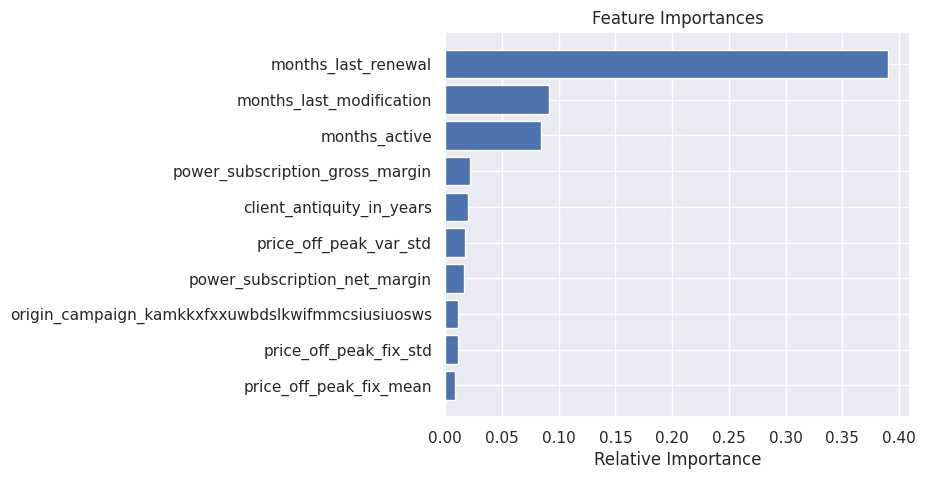

In [53]:

rf_model = pickle.load(open(rf_model_file, 'rb'))

features = [i.split("__")[0] for i in X_unscaled.columns]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]

fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Revisit the columns with high importances

<Axes: xlabel='months_last_renewal', ylabel='Count'>

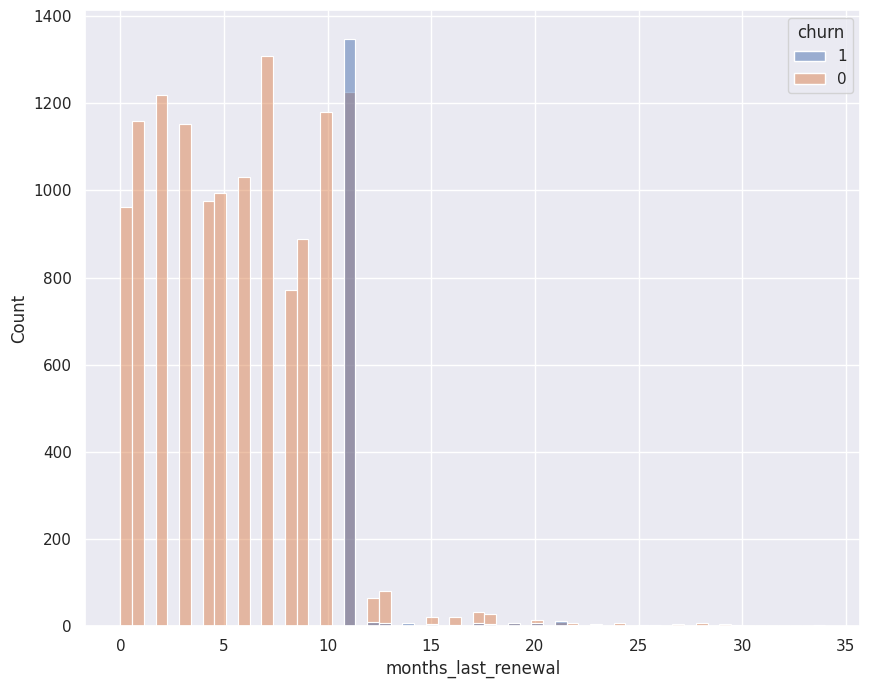

In [59]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.histplot(data=df, x='months_last_renewal', hue='churn')

<Axes: xlabel='months_last_modification', ylabel='Count'>

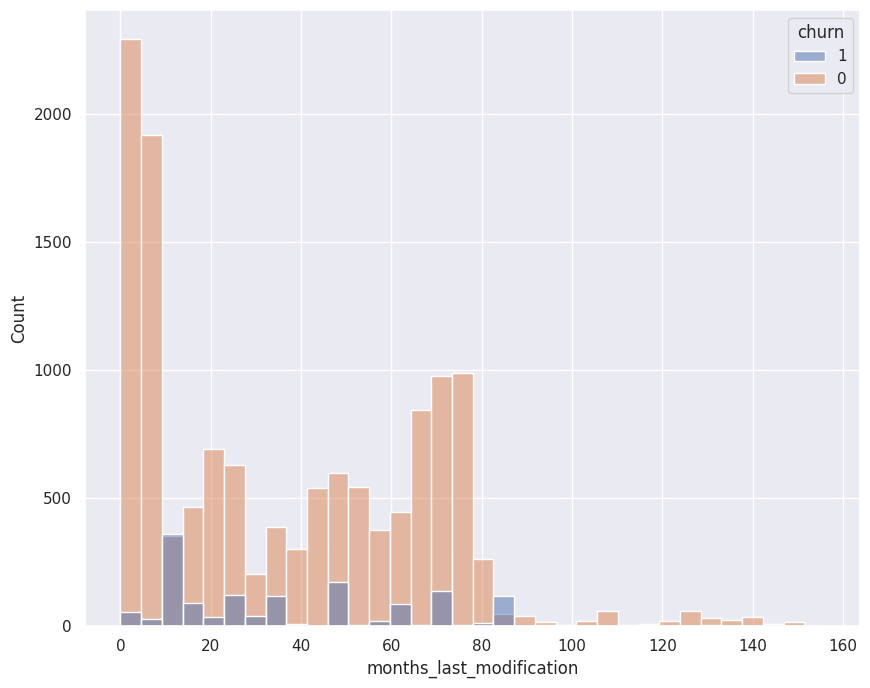

In [60]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.histplot(data=df, x='months_last_modification', hue='churn')

<Axes: xlabel='months_active', ylabel='Count'>

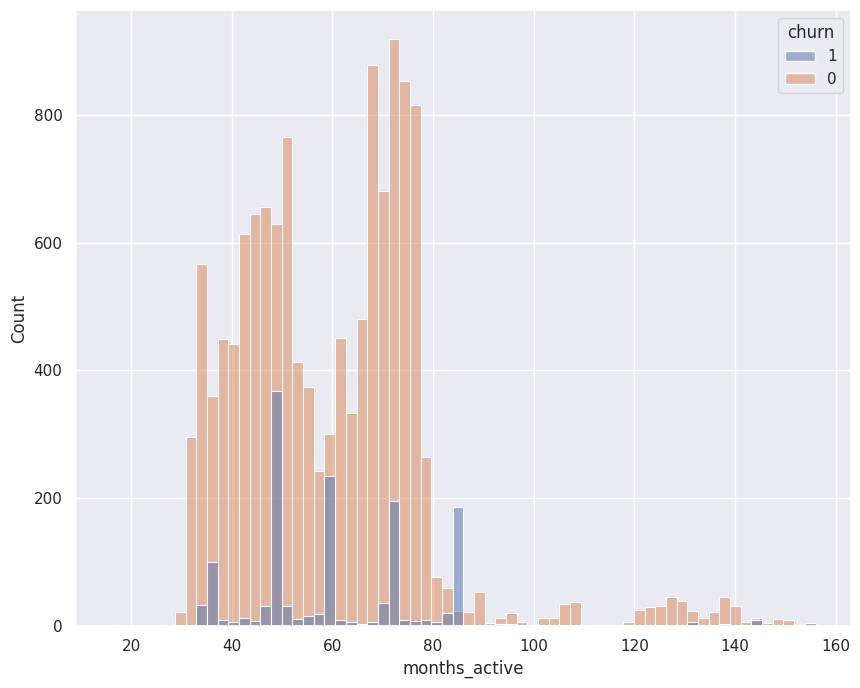

In [62]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.histplot(data=df, x='months_active', hue='churn')